In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import pandas as pd
# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# Model
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Read Data from File

In [48]:
df = pd.read_csv("music_genre.csv")
df.head(5)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


# Removing Junk and Converting Data to Usable Values

Null values, duplicates, and unnecessary columns (instance_id and obtained_date) are all removed.
The mode and key are each converted into values by an encoder.

In [49]:
# Drop junk
df = df.dropna(axis=0)
df.drop_duplicates(subset = df.columns.difference(['music_genre']), inplace = True, ignore_index = True)
df.drop(columns=['instance_id','obtained_date'], inplace = True,axis=1)

In [50]:
# Convert to usable
df[['key','mode']] = OrdinalEncoder().fit_transform(df[['key','mode']])
df['tempo'].replace(to_replace = '?', value =-1.0, inplace=True)
df['instrumentalness'].replace(to_replace = 0.0, value =-1.0, inplace=True)
df['tempo'] = pd.to_numeric(df['tempo'])
imp = SimpleImputer(missing_values = -1.0, strategy = 'median')
df[['tempo','duration_ms','instrumentalness']] = imp.fit_transform(df[['tempo','duration_ms','instrumentalness']])

In [51]:
# Encode string values
#le = LabelEncoder()
#for col in encode:
#    df[col] = le.fit_transform(df[col])
# Remove encodable values
encode = ["artist_name","track_name"]
df.drop(columns=encode, inplace = True,axis=1)
df.head(5)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,1.0,0.115,-5.201,1.0,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5.0,0.124,-7.043,1.0,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11.0,0.534,-4.617,0.0,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4.0,0.157,-4.498,0.0,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9.0,0.157,-6.266,0.0,0.0413,145.036,0.323,Electronic


# Feature Selection

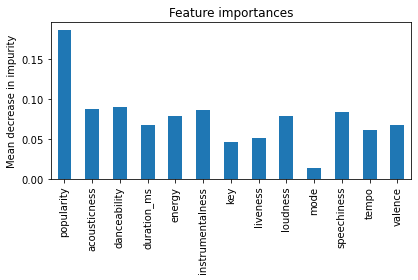

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
selector = ExtraTreesClassifier().fit(df.drop(columns=['music_genre'], axis=1), df['music_genre'])
importances = selector.feature_importances_

features = list(df.drop(columns=['music_genre'], axis=1).columns)
tree_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

df.drop(columns=(tree_importances[tree_importances < 0.05]).index, inplace = True,axis=1)

# Set up Train and Test Data

In [53]:
X = df.drop(columns=['music_genre'], axis=1)
Y = df['music_genre']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# Decision Tree Classifier

Decision Tree accuracy is: 45.09%


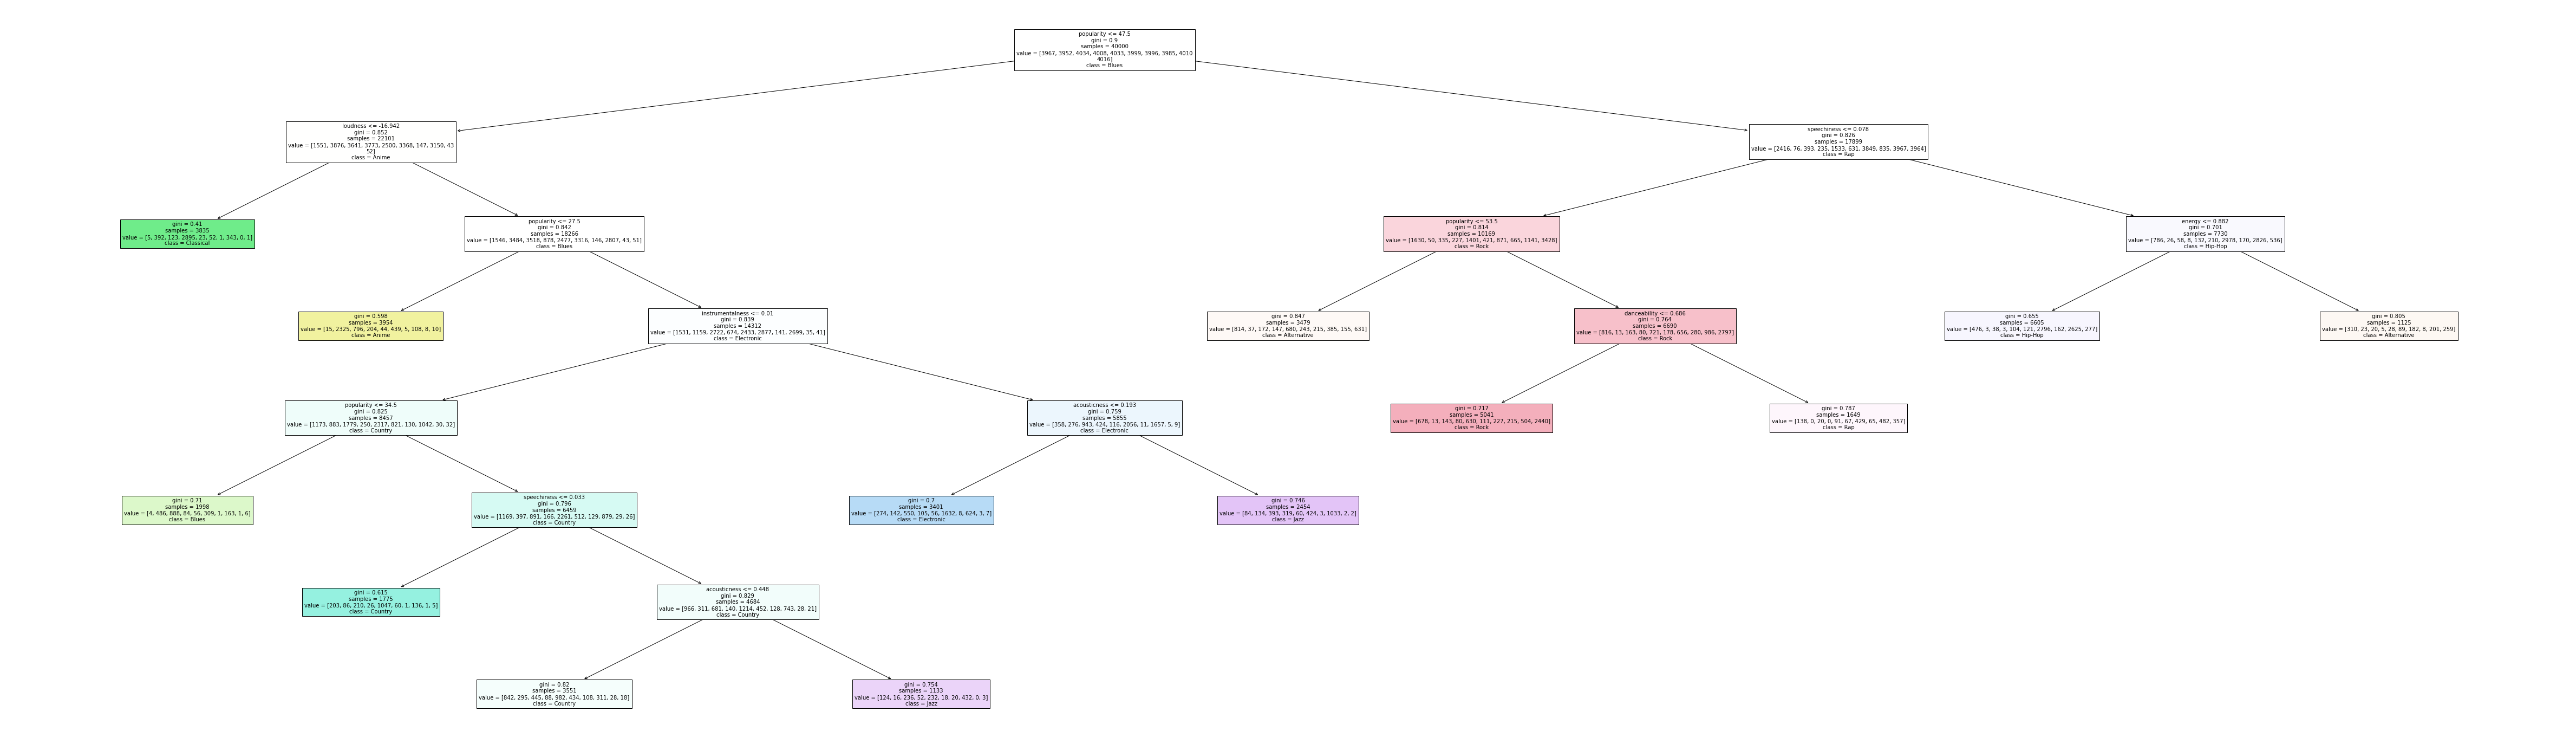

In [86]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Overfit
#DTclassifier = DecisionTreeClassifier(max_leaf_nodes=30).fit(X_train, Y_train)
# Intuitive Fit
#DTclassifier = DecisionTreeClassifier(min_impurity_decrease=0.00175,min_samples_leaf=1000,max_leaf_nodes=30).fit(X_train, Y_train)
# Reduced Intuitive Fit
DTclassifier = DecisionTreeClassifier(min_samples_split=0.1,min_impurity_decrease=0.00175,min_samples_leaf=1000,max_leaf_nodes=30).fit(X_train, Y_train)
# Minimal Fit
#DTclassifier = DecisionTreeClassifier(min_impurity_decrease=0.01,min_samples_leaf=1000,max_leaf_nodes=30).fit(X_train, Y_train)

Y_pred = DTclassifier.predict(X_test)

DTAcc = accuracy_score(Y_pred,Y_test) # Calculating accuracy
print('Decision Tree accuracy is: {:.2f}%'.format(DTAcc*100))
plt.figure(figsize=(85,25))
tree.plot_tree(decision_tree=DTclassifier, feature_names=list(X.columns), filled=True, class_names=sorted(Y.unique()), fontsize=10)
plt.show()

# Grab Values to Predict

In [68]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '10f92907722c44d5a24ed6486e961379'
secret = 'b1c12d2638ed4996a4b72ab313f49f1b'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

In [93]:
artist= input("Enter artist name: ")
track= input("Enter track name: ")

found = sp.search(q='artist:' + artist + ' track:' + track, type='track')
trackId = found['tracks']['items'][0]['id']

audio_features = sp.audio_features(trackId)[0]
sample = pd.DataFrame.from_dict([audio_features])
df_sample = df.median()

df_sample['popularity'] = found['tracks']['items'][0]['popularity']
df_sample['danceability'] = sample['danceability'].values[0]
df_sample['energy'] = sample['energy'].values[0]
df_sample['loudness'] = sample['loudness'].values[0]
df_sample['speechiness'] = sample['speechiness'].values[0]
df_sample['acousticness'] = sample['acousticness'].values[0]
df_sample['instrumentalness'] = sample['instrumentalness'].values[0]
df_sample['valence'] = sample['valence'].values[0]
df_sample['tempo'] = sample['tempo'].values[0]
df_sample['duration_ms'] = sample['duration_ms'].values[0]

print("Predicted Genre: ",DTclassifier.predict([df_sample])[0])

Enter artist name:  The Strokes
Enter track name:  The Adults Are Talking


Predicted Genre:  Rock
